In [7]:
# !pip install yahoo_fin

In [4]:
from yahoo_fin import stock_info as finance
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [5]:
finance.get_data('SPY', '20200101', '20230101').head()

,open,high,low,close,adjclose,volume,ticker
2020-01-02,323.540009,324.890015,322.529999,324.869995,306.295258,59151200,SPY
2020-01-03,321.160004,323.640015,321.100006,322.410004,303.975952,77709700,SPY
2020-01-06,320.489990,323.730011,320.359985,323.640015,305.135681,55653900,SPY
2020-01-07,323.019989,323.540009,322.239990,322.730011,304.277557,40496400,SPY
2020-01-08,322.940002,325.779999,322.670013,324.450012,305.899353,68296000,SPY


In [6]:
def return_etf_holdings(ticker = 'SPY'):

    headers = requests.utils.default_headers()
    headers['User-Agent'] = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'
    res = requests.get("https://www.zacks.com/funds/etf/%s/holding"%ticker,  headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')

    js = None
    for script in soup.find_all("script"):
        if "etf_holdings.formatted_data = " in str(script):
    #    if "etf_holdings" in str(script):
            js = str(script)
    holdings = []
    # for line in js.text.split("["):
    for line in js.split("["):
        if "rel=" in line:
            line_soup = BeautifulSoup(line, 'html.parser')
            #holding = line_soup.find("a")["alt"].strip('\\"')
            holding = line_soup.find('a')['rel'][0].strip('\\"')
            holdings.append(holding)

    return holdings

In [8]:
# Short sale volume

class ShortSaleVolume:
    
    bucket = 'mads-capstone-2023' 
    data_key = 'FINRA_Short_Sale_Data2.csv' 
    data_location = 's3://{}/{}'.format(bucket, data_key) 
    
    def __init__(self):
        self.has_downloaded = False 
    
    # Function to download data from S3
    def get_data(self):
        if not self.has_downloaded:
            self.df = pd.read_csv(self.data_location)
            self.df.drop(['Unnamed: 0'], axis = 1, inplace = True)
            self.df['shortvolume'] = self.df['totalvolume'] - self.df['shortvolume']
            self.df['longvolume'] = self.df['totalvolume'] - self.df['shortvolume']
            self.df['short_ratio'] = 1 - self.df['short_ratio']
            self.has_downloaded = True
        else:
            pass
        
    def short_ratio(self, ticker):
        # Check if data has been downloaded locally
        self.get_data()
        
        # Return data for ticker 
        df_ = self.df[self.df['ticker'] == ticker].copy()
        df_['date'] = pd.to_datetime(df_['date'])
        df_.set_index('date', inplace=True)
        return df_

    
    def calculate_short_ratio_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]
        for period in periods:
            df[f'short_ratio_mean_{period}'] = df['short_ratio'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_ratio_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_ratio_mean_{periods[i]}'] / df[f'short_ratio_mean_{periods[j]}']
                    df[f'short_ratio_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_ratio_mean_{periods[j]}'] / df[f'short_ratio_mean_{periods[i]}']

        if include_roc:
            # print('working')
            for col in df.columns:
                if 'short_ratio_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_ratio_mean_' in col or ('roc' in col and 'short_ratio_mean_' in col)]]
        return result_df

    def calculate_short_exempt_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]

        df['short_exempt_percent'] = (df['shortexemptvolume'] / df['totalvolume'])

        for period in periods:
            df[f'short_exempt_percent_mean_{period}'] = df['short_exempt_percent'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_exempt_percent_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_exempt_percent_mean_{periods[i]}'] / df[f'short_exempt_percent_mean_{periods[j]}']
                    df[f'short_exempt_percent_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_exempt_percent_mean_{periods[j]}'] / df[f'short_exempt_percent_mean_{periods[i]}']

        if include_roc:
            for col in df.columns:
                if 'short_exempt_percent_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_exempt_percent_mean_' in col or ('roc' in col and 'short_exempt_percent_mean_' in col)]]
        return result_df
    
    def calculate_investment_values(self, ticker='GME', days=20, investment_amount=1_000_000, include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)

        # Retrieve closing prices from finance API
        closing_prices = finance.get_data(ticker, df.index.min(), df.index.max())['close']
        
        # Merge closing prices with short ratio data
        df = df.merge(closing_prices, left_index=True, right_index=True, how='left')

        # Ensure short_exempt_percent column is calculated before its usage
        df['short_exempt_percent'] = df['shortexemptvolume'] / df['totalvolume']

        # Calculate net short volume and net short shares
        df['net_short_volume'] = df['shortvolume'] - df['longvolume']
        df['net_short_shares'] = investment_amount / df['close']

        # Calculate cumulative net short volume and short exempt volume
        df['cumulative_net_short'] = (df['net_short_volume'] * df['net_short_shares']).rolling(window=days).sum()
        df['cumulative_short_exempt'] = (df['short_exempt_percent'] * df['net_short_shares']).rolling(window=days).sum()

        # Calculate the cumulative values as a percent of total volume
        df['cumulative_net_short_percent'] = df['cumulative_net_short'] / (df['totalvolume'] * df['net_short_shares']).rolling(window=days).sum() * 100
        df['cumulative_short_exempt_percent'] = df['cumulative_short_exempt'] / (df['totalvolume'] * df['net_short_shares']).rolling(window=days).sum() * 100

        if include_diff:
            periods = [1, 5, 10, 21, 42]
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'cumulative_net_short_percent_{periods[i]}_div_{periods[j]}'] = df['cumulative_net_short_percent'].rolling(window=periods[i]).mean() / df['cumulative_net_short_percent'].rolling(window=periods[j]).mean()
                    df[f'cumulative_short_exempt_percent_{periods[i]}_div_{periods[j]}'] = df['cumulative_short_exempt_percent'].rolling(window=periods[i]).mean() / df['cumulative_short_exempt_percent'].rolling(window=periods[j]).mean()

        if include_roc:
            for col in ['cumulative_net_short_percent', 'cumulative_short_exempt_percent']:
                df[f'{col}_roc'] = df[col].pct_change() * 100

        selected_cols = ['cumulative_net_short_percent', 'cumulative_short_exempt_percent']
        if include_diff or include_roc:
            selected_cols += [col for col in df.columns if 'cumulative_net_short_percent' in col or 'cumulative_short_exempt_percent' in col]

        return df[selected_cols]

# Example usage 
analysis = ShortSaleVolume()
df_gme_short_ratio = analysis.calculate_short_ratio_means('GME', include_roc = False)
df_gme_short_sale_exempt = analysis.calculate_short_exempt_means('GME', include_roc = False)
df_gme_investment_values = analysis.calculate_investment_values('GME', include_roc = False)


In [9]:
df_gme_short_ratio.head()

,short_ratio_mean_1,short_ratio_mean_5,short_ratio_mean_10,short_ratio_mean_21,short_ratio_mean_42
date,,,,,
2018-08-01,0.491204,NaN,NaN,NaN,NaN
2018-08-02,0.400319,NaN,NaN,NaN,NaN
2018-08-03,0.302492,NaN,NaN,NaN,NaN
2018-08-06,0.345414,NaN,NaN,NaN,NaN
2018-08-07,0.524622,0.41281,NaN,NaN,NaN


In [10]:
df_gme_short_sale_exempt.head()

,short_exempt_percent_mean_1,short_exempt_percent_mean_5,short_exempt_percent_mean_10,short_exempt_percent_mean_21,short_exempt_percent_mean_42
date,,,,,
2018-08-01,0.002141,NaN,NaN,NaN,NaN
2018-08-02,0.000745,NaN,NaN,NaN,NaN
2018-08-03,0.000000,NaN,NaN,NaN,NaN
2018-08-06,0.000000,NaN,NaN,NaN,NaN
2018-08-07,0.000000,0.000577,NaN,NaN,NaN


In [11]:
df_gme_investment_values

,cumulative_net_short_percent,cumulative_short_exempt_percent
2018-08-01,NaN,NaN
2018-08-02,NaN,NaN
2018-08-03,NaN,NaN
2018-08-06,NaN,NaN
2018-08-07,NaN,NaN
...,...,...
2023-11-01,-26.279171,6.225531e-07
2023-11-02,-25.884034,6.323761e-07
2023-11-03,-27.054611,6.088986e-07
2023-11-06,-27.377643,5.615689e-07


<AxesSubplot:>

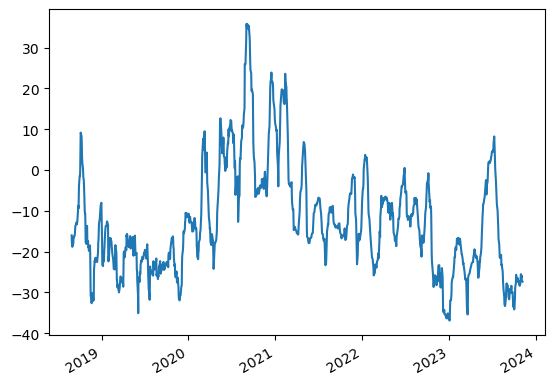

In [12]:
df_gme_investment_values.dropna()['cumulative_net_short_percent'].plot()

In [35]:
# !pip install psycopg2

In [25]:
import psycopg2
import pandas as pd

class GreekAnalysis:
    def __init__(self):
        self.db_params = {
            'user': 'postgres',
            'password': 'Data2023',
            'host': 'mads-capstone.cmohac77hep9.eu-north-1.rds.amazonaws.com',
            'port': 5432,
            'database': 'mads'
        }

    def get_greeks_data(self, ticker, greek_type):
        with psycopg2.connect(**self.db_params) as db_connection:
            db_connection.autocommit = True
            with db_connection.cursor() as cursor:
                select_query = "SELECT * FROM greeks3 WHERE ticker=%s AND GREEK=%s"
                cursor.execute(select_query, (ticker, greek_type))
                rows = cursor.fetchall()
                df = pd.DataFrame(rows, columns=["ID", "DATE", "INCREMENT", "VALUE", "TICKER", "GREEK", "OPTION_TYPE"])
        return df

    def analyze_data(self, df, greek_type):
        merged_df = self._prepare_merged_dataframe(df, greek_type)
        merged_df[f'{greek_type}_Skew'] = merged_df[f'{greek_type}_Call'] / merged_df[f'{greek_type}_Put']
        merged_df[f'{greek_type}_Time_Spread'] = merged_df[f'{greek_type}_30'] / merged_df[f'{greek_type}_90']
        return merged_df[[f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']]

    def _prepare_merged_dataframe(self, df, greek_type):
        inc30_all = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'all')]
        inc30_call = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'call')]
        inc30_put = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'put')]
        inc90_all = df[(df['INCREMENT'] == 90) & (df['OPTION_TYPE'] == 'all')]

        merged_df = pd.DataFrame(index=inc30_all['DATE'].unique())
        merged_df[f'{greek_type}_30'] = inc30_all.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Call'] = inc30_call.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Put'] = inc30_put.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_90'] = inc90_all.groupby('DATE')['VALUE'].mean()

        return merged_df

    def _add_rolling_features(self, df, greek_type):
        periods = [1, 5, 10, 21, 42]
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            for period in periods:
                df[f'{col}_rolling_{period}'] = df[col].rolling(window=period).mean()
        return df

    def _add_z_score_features(self, df, greek_type):
        rolling_window = 90
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            df[f'{col}_z_score'] = (df[col] - df[col].rolling(window=rolling_window).mean()) / df[col].rolling(window=rolling_window).std()
        return df

    def get_analysis_for_ticker(self, ticker, greek_type='iv', include_rolling=False, include_z_score=False):
        df = self.get_greeks_data(ticker, greek_type)
        analysis_df = self.analyze_data(df, greek_type)
        if include_rolling:
            analysis_df = self._add_rolling_features(analysis_df, greek_type)
        if include_z_score:
            analysis_df = self._add_z_score_features(analysis_df, greek_type)
        return analysis_df.sort_index()

# Example usage:
analysis = GreekAnalysis()
df_gme_iv = analysis.get_analysis_for_ticker('GME', 'iv', include_rolling = False, include_z_score = True)
df_gme_gamma = analysis.get_analysis_for_ticker('GME', 'gamma', include_rolling = False, include_z_score = True)


In [26]:
df_gme_iv.tail()

,iv_30,iv_Skew,iv_Time_Spread,iv_30_z_score,iv_Skew_z_score,iv_Time_Spread_z_score
2023-11-10,0.7930,1.079794,0.987301,0.516822,-0.249425,0.164255
2023-11-13,0.8262,1.084479,1.015362,0.924048,-0.199672,0.873496
2023-11-14,0.7667,1.029561,0.956820,0.134486,-0.931681,-0.658507
2023-11-15,0.7964,0.989163,0.976938,0.510061,-1.423678,-0.132876
2023-11-16,0.7992,1.130657,0.965567,0.531883,0.416216,-0.426959


In [27]:
df_gme_gamma.tail()

,gamma_30,gamma_Skew,gamma_Time_Spread,gamma_30_z_score,gamma_Skew_z_score,gamma_Time_Spread_z_score
2023-11-10,111919.550,-1.316120,2.224361,-0.021123,0.011226,0.040089
2023-11-13,-33579.246,-0.910017,0.303222,-0.527586,0.577274,-0.203795
2023-11-14,675779.800,-2.570342,1.104932,2.038024,-1.786298,-0.102172
2023-11-15,879739.700,-2.925758,1.045916,2.717992,-2.220881,-0.109874
2023-11-16,-56497.227,-0.922184,0.392609,-0.590756,0.547914,-0.192270


In [28]:
class VolatilityAnalysis(GreekAnalysis):
    def __init__(self):
        super().__init__()
        self.sdate = '20160101'
        self.edate = '20231110'
        
    # Function to calculate HV for a given OHLCV DataFrame
    def calculate_hv(self, ohlcv_df, look_forward=30):
        # Calculate daily returns
        daily_returns = ohlcv_df['close'].pct_change()

        # Compute rolling standard deviation of daily returns
        rolling_std = daily_returns.rolling(window = look_forward).std()

        # HV is the annualized standard deviation
        hv = rolling_std * np.sqrt(252)

        return hv

    def compare_iv_hv(self, ticker, shift_hv = False):
        
        # Get ticker data
        ohlcv_df = finance.get_data(ticker, self.sdate, self.edate)
        
        # Pull IV30 data
        iv30_df = self.get_greeks_data(ticker, 'iv')
        iv30_df = iv30_df[(iv30_df['GREEK'] == 'iv') & (iv30_df['OPTION_TYPE'] == 'all') & (iv30_df['INCREMENT'] == 30)].copy()
        iv30_df['date'] = pd.to_datetime(iv30_df['DATE'])
        iv30_df.rename({'VALUE':'iv30'}, inplace = True, axis = 1)

        # Calculate HV
        hv_df = self.calculate_hv(ohlcv_df)

        # Align and compare IV30 and HV
        # Ensure iv30_df and hv_df have the same date index
        comparison_df = pd.DataFrame()
        comparison_df['IV30'] = iv30_df.set_index('date').sort_index()['iv30']
        
        # Are we shifting HV? 
        if shift_hv:
            comparison_df['HV'] = hv_df.shift(-30)  # Adjust as necessary
        else:
            comparison_df['HV'] = hv_df
        
        # Add to dataframe and return 
        comparison_df['IV_HV_Difference'] = comparison_df['IV30'] - comparison_df['HV']

        return comparison_df['IV_HV_Difference']
    
    def calculate_vwap(self, ohlcv_df, rolling_window = 90):  
        ohlcv_df['Typical_Price'] = (ohlcv_df['high'] + ohlcv_df['low'] + ohlcv_df['close']) / 3
        ohlcv_df['TP_Volume'] = ohlcv_df['Typical_Price'] * ohlcv_df['volume']

        # Calculate rolling TP_Volume and rolling volume
        ohlcv_df['Rolling_TP_Volume'] = ohlcv_df['TP_Volume'].rolling(window=rolling_window).sum()
        ohlcv_df['Rolling_Volume'] = ohlcv_df['volume'].rolling(window=rolling_window).sum()

        # Compute rolling VWAP
        ohlcv_df['VWAP'] = ohlcv_df['Rolling_TP_Volume'] / ohlcv_df['Rolling_Volume']

        # Calculate the percentage difference between close and VWAP
        ohlcv_df['vwap_close_pct'] = ohlcv_df['close'] / ohlcv_df['VWAP']

        return ohlcv_df

    def compare_price_to_vwap(self, ticker = None, ohlcv_df = None):
        
        # Optionally, grab data
        if not isinstance(ohlcv_df, pd.DataFrame):
            ohlcv_df = finance.get_data(ticker, self.sdate, self.edate)
            
        ohlcv_df = self.calculate_vwap(ohlcv_df)
        return ohlcv_df['vwap_close_pct']
    
# Example usage
analysis = VolatilityAnalysis()
df_iv_hv = analysis.compare_iv_hv('GME')
df_vwap = analysis.compare_price_to_vwap('GME')

In [29]:
df_iv_hv.dropna().head()

date
2016-02-17    0.112270
2016-02-18    0.094677
2016-02-19    0.073292
2016-02-22    0.032936
2016-02-23    0.019996
Name: IV_HV_Difference, dtype: float64

In [30]:
## Create dataframe of training data

# Short sale ratio
# Short exempt ratio 
# IV / Gamma
# Vol analysis 

In [31]:
# Instantiate needed classes
short_sale = ShortSaleVolume()
greeks = GreekAnalysis()
vol = VolatilityAnalysis()

In [80]:
import random

tickers = return_etf_holdings('SPY')
tickers = random.sample(tickers, k = 100)
tickers.append('GME')
tickers.append('SPY')
tickers = list(set(tickers))
tickers[:5]

['WAT', 'ATO', 'TYL', 'CHRW', 'AEP']

In [81]:
from tqdm import tqdm

# Download SPY data
sdate = '20160101'
edate = '20231115'
df_spy = finance.get_data('SPY', sdate, edate)
normalize_to_spy = False

# Initialize a dictionary to hold the z-score analysis results
df_repo = {}

# Define a function to calculate normalized returns
def calculate_normalized_returns(df_ticker, df_spy, window = 5):
    # Calculate 1-week returns for the stock and SPY
    df_ticker['1_week_return'] = df_ticker['close'].pct_change(window)
    df_spy['1_week_return'] = df_spy['close'].pct_change(window)
    
    # Normalize the stock's 1-week returns by SPY's 1-week returns
    df_ticker['normalized_return'] = df_ticker['1_week_return'] / df_spy['1_week_return']
    
    return df_ticker['normalized_return']

def calculate_unnormalized_returns(df_ticker, window = 5):
    df_ticker['1_week_return'] = df_ticker['close'].pct_change(window)
    return df_ticker['1_week_return']
    

# Define a function to calculate z-scores
def calculate_z_scores(data, window = 252):
    # Calculate rolling mean and standard deviation
    mean = data.rolling(window, min_periods = 5).mean()
    std = data.rolling(window, min_periods = 5).std()
    
    # Calculate z-scores
    z_scores = (data - mean) / std
    
    return z_scores

# Loop through each ticker and perform calculations
for ticker in tqdm(tickers):
    
    try:
        # Download stock data
        df_ticker = finance.get_data(ticker, sdate, edate)

        # Calculate normalized returns
        if normalize_to_spy:
            df_ticker['returns'] = calculate_normalized_returns(df_ticker, df_spy)
        else:
            df_ticker['returns'] = calculate_unnormalized_returns(df_ticker)

        # Calculate z-scores for the normalized returns
        df_ticker['z_score_returns'] = calculate_z_scores(df_ticker['returns'])

        # Store the dates where the z-score indicates an outsized move
        # z_score_analysis[ticker] = stock_data.index[stock_data['z_score'].abs() > 2].tolist()
        # df_ticker.rename({'z_score' : ticker}, inplace = True, axis = 1)
        
        # Get short_ratio and short_exempt data
        df_short_ratio = short_sale.calculate_short_ratio_means(ticker, include_diff=True, include_roc=True)
        df_short_sale_exempt = short_sale.calculate_short_exempt_means(ticker, include_diff=True, include_roc=True)
        df_gme_investment_values = short_sale.calculate_investment_values(ticker, include_diff=True, include_roc=True)
        
        # IV30, IV Skew, IV Time Spread (IV30 vs IV90), 
        # Gamma30, Gamma Skew, Gamme Time Spread (30 vs 90)
        df_iv = greeks.get_analysis_for_ticker(ticker, 'iv', include_rolling = True, include_z_score = True)
        df_gamma = greeks.get_analysis_for_ticker(ticker, 'gamma', include_rolling = True, include_z_score = True)
        
        # IV vs Actual Vol, Price vs rolling VWAP
        df_iv_hv = vol.compare_iv_hv(ticker)
        df_vwap = vol.compare_price_to_vwap(ticker)
        
        ## Add to single dataframe
        # Short ratio etc
        df_ticker = df_ticker.join(df_short_ratio).join(df_short_sale_exempt).join(df_gme_investment_values)
        # Greeks
        df_ticker = df_ticker.join(df_iv).join(df_gamma).dropna()
        # Vol analysis 
        df_ticker = df_ticker.join(df_iv_hv).join(df_vwap)
        
        # Drop unneeded OHLCV columns and store in repo dictionary
        df_repo[ticker] = df_ticker.drop(df_ticker.columns[:9], axis = 1)
        
    except Exception as e:
        print(ticker, type(e), e) 
    

# z_score_analysis now contains the tickers and the dates with outsized moves


100%|██████████| 102/102 [08:04<00:00,  4.75s/it]


<AxesSubplot:>

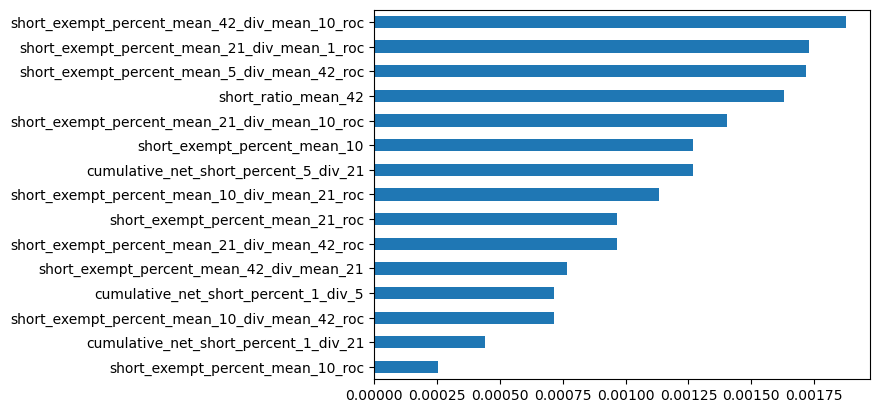

In [34]:
df_data = pd.concat(df_repo.values()).reset_index().drop('index', axis = 1).dropna()


## Correlation 
df_data.corr()['z_score_returns'].abs().sort_values(ascending = True).drop('z_score_returns').iloc[:15].plot.barh()

In [23]:
# Determine the lower and upper thresholds
lower_threshold = df_data.quantile(0.02)  # 1st percentile
upper_threshold = df_data.quantile(0.98)  # 99th percentile

# Cap the values in each column
for col in df_data.columns:
    if df_data[col].dtype.kind in 'biufc':  # Check if the column is numeric
        df_data[col] = df_data[col].clip(lower_threshold[col], upper_threshold[col])

In [24]:
## Correlation 
df_data.corr()['z_score_returns'].abs().sort_values(ascending = True).drop('z_score_returns').plot.barh()

In [25]:
# Replace inf/-inf with NaN
df_data = df_data.replace([np.inf, -np.inf], np.nan).dropna()

## Correlation 
df_data.corr()['z_score_returns'].abs().sort_values(ascending = True).drop('z_score_returns').plot.barh()

In [135]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [22]:
# Preprocessing
X = df_data.drop('z_score_returns', axis=1)
y = df_data['z_score_returns']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# Assuming df is your DataFrame


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# Prediction and Evaluation
predictions = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

# Cross-Validation
scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
cv_rmse = np.sqrt(-scores)
print(f"CV RMSE: {cv_rmse.mean()}")


In [28]:
from sklearn.metrics import r2_score

print('R2 score: ', r2_score(y_test, predictions))

In [125]:
#!pip install lightgbm
from lightgbm import LGBMRegressor, plot_importance
from sklearn.feature_selection import RFE

class RegressorRFE:

    def __init__(self, model_type='regressor', random_state = 42, verbose = 3, lookforward_bias_window = 0):
        # Choose between regressor or classifier
        self.model_type = model_type

        # Light GBM parameters for primary regressor
        self.params = {
            'n_jobs': 28,
            'max_depth': -1,  # <0 == infinite
            'n_estimators': 2500,
            'early_stopping_round': 250, # Should be at 10% of n_estimators
            'random_state': random_state,
            'device': 'cpu',
            'boosting' : 'dart',
        }

        # Light GBM parameter for RFE regressor
        self.rfe_params = {
            'n_jobs': 28,
            'max_depth': -1,  # <0 == infinite
            'n_estimators': 200,
            'early_stopping_round': 20, # Should be at 10% of n_estimators
            'boosting_type' : 'dart',
            'max_bin': 63,
            'random_state': random_state,
            'device': 'cpu',
            'num_leaves': 15,
            'colsample_bytree': .5, # alias of feature_fraction
            'subsample' : .5,
            'max_depth' : 6
        }

        # Settings for RFE
        self.n_features_to_select = 15
        self.step = .5
        self.verbose = verbose
        self.X_rfe = None
        self.ranking_ = None

        # Repo for column names
        self.columns_ = None
        self.valid_columns_ = None

        # To prevent lookahead bias
        self.lookforward_bias_window = lookforward_bias_window

    def get_model(self, model_params):
        if self.model_type == 'regressor':
            return LGBMRegressor(**model_params)
        elif self.model_type == 'classifier':
            return LGBMClassifier(**model_params)

    def fit_transform_data(self, X, y):
        # Check for any categorical features
        # self._check_for_categorical_features(X)

        # Instantiate model
        model = self.get_model(self.rfe_params)

        # Instantiate and run RFE
        selector = RFE(model, n_features_to_select=self.n_features_to_select, step=self.step, verbose=self.verbose)

        # Check if lookforward bias is being taken into account
        X_train, y_train = self._eliminate_lookforward_bias(X, y)

        if self.verbose == 3:
            print('Final date in training: ', X_train.index[-1])

        # Train RFE
        selector.fit(X_train, y_train)
        self.selector = selector
        self.ranking_ = selector.ranking_

        # Save column names, if necessary
        if isinstance(X, pd.DataFrame):
            # Save column names
            self.all_columns_ = X.columns
            # Isolate valid columns
            self.valid_columns_ = [x[1][0] for x in enumerate(zip(self.all_columns_, self.ranking_==1)) if x[1][1]]
            # Return dataframe only containing these columns
            return X[[x for x in X.columns if x in self.valid_columns_]]

        # Return transformed data
        return X[:, self.ranking_ == 1]

    def fit(self, X, y):
        self.X_rfe = self.fit_transform_data(X, y)
        model = self.get_model(self.params)
        return model.fit(self.X_rfe.values, y)

    def _check_for_categorical_features(self, X):
        # Parse out any categorical features from the input data
        # categorical_features = [x for x in (X.dtypes == object).where(lambda x: x).dropna().index.values]
        categorical_features = [ str(i[0]) for i in enumerate ( (X.dtypes == object).values ) if i[1]]
        # Parse together into string format per LightGBM documentation
        # str_ = 'name:' + ','.join( categorical_features )
        str_ = ','.join( categorical_features )
        # Add to dictionary parameters
        self.rfe_params['categorical_feature'] = str_
        self.params['categorical_feature'] = str_

    def _eliminate_lookforward_bias(self, X, y):
        if self.lookforward_bias_window == 0:
            return X, y
        else:
            return X.iloc[0:len(X) - self.lookforward_bias_window], y.iloc[0:len(y) - self.lookforward_bias_window]

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            if self.valid_columns_ == None:
                print('Instance has not been trained. Must first use fit_transform_data() method.')
            return X[[x for x in X.columns if x in self.valid_columns_]]
        elif isinstance(X, pd.Series):
            return X.loc[self.valid_columns_]
        return X[:, self.ranking_ == 1]

    
class FeatureImportances:

    def __init__(self):
        pass

    ## Function to return feature importances information given an X_train and y_train variables
    def feature_importances(X_train, y_train, column_names, return_feature_importances = False, verbose = 0):
        """
        Column names list should come from Polynomial Features function.

        X_train(_poly) will likely be the X_train_poly from the Polynomial Features function as opposed to
        the regular X_train
        """

        # Instantiate class
        model_obj = RegressorRFE()
        model_obj.verbose = 0

        # Fit data
        model = model_obj.fit(X_train, y_train)

        # Create dataframe containing column names
        df = pd.DataFrame(X_train)
        df.columns = column_names
        df = df.loc[:, (model_obj.ranking_ ==  1)]
        columns_X_test = list(df.columns)

        # Organize feature importances
        feat_importances = pd.Series(model.feature_importances_, index=columns_X_test)

        # Optionally, return them
        if return_feature_importances:
            return feat_importances

        # Return plot (for Jupyter notebook)
        feat_importances.sort_values(ascending = True).plot(kind='barh', figsize = (20, 10))

In [23]:

# Instantiate class
model_obj = RegressorRFE()
model_obj.verbose = 3

# Fit data
model = model_obj.fit(X_train, y_train)




Final date in training:  15795
Fitting estimator with 170 features.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 37841, number of used features: 170
[LightGBM] [Info] Start training from score -0.046640


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:292: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fitting estimator with 85 features.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 37841, number of used features: 85
[LightGBM] [Info] Start training from score -0.046640


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:292: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 37841, number of used features: 15
[LightGBM] [Info] Start training from score -0.046640


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:292: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 37841, number of used features: 15
[LightGBM] [Info] Start training from score -0.046640


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:292: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


In [26]:
columns_X_test = list(model_obj.valid_columns_)
X_test[columns_X_test]

,iv_30_rolling_21,iv_30_rolling_42,iv_30_z_score,iv_Skew_z_score,gamma_30,gamma_Skew,gamma_30_rolling_10,gamma_30_rolling_21,gamma_Skew_rolling_1,gamma_Skew_rolling_10,gamma_Skew_rolling_21,gamma_30_z_score,gamma_Skew_z_score,IV_HV_Difference,vwap_close_pct
5345,0.543448,0.588793,-0.894235,-0.187947,18739.7050,-1.251466,13910.59466,6126.200076,-1.251466,-1.331578,-1.123694,0.192464,0.151014,0.142474,0.975505
13459,0.366957,0.372038,-0.604440,0.381315,486.7017,-2.471662,-4159.55542,-4591.441457,-2.471662,-2.100100,-1.057893,0.587601,-0.695642,0.056689,0.993080
27440,0.380800,0.333145,-0.164284,-1.093594,168.5480,-1.100978,4766.68530,4698.344833,-1.100978,-1.825980,-1.601380,-0.721830,0.655442,0.079290,0.948154
33180,0.693495,0.724462,0.406905,0.720818,36379.6400,-2.866604,38949.35590,24685.191586,-2.866604,-1.940259,-1.781466,-0.175005,-0.294016,0.194245,1.416468
30021,0.204343,0.217288,-0.147557,0.247675,-4203.9490,-0.967349,53766.44856,47795.775410,-0.967349,-1.258753,-1.280005,-0.680776,0.711334,0.050087,0.956658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33806,0.301105,0.351224,-1.371864,-0.098326,245.2981,-5.325147,154.95005,551.779257,-5.325147,-3.815734,-3.825765,-0.681555,-0.504987,0.004504,1.136952
13831,0.689500,0.673971,1.407449,-0.471626,337899.9000,-2.222095,371858.33650,346016.379762,-2.222095,-2.551623,-2.419582,0.127769,0.676636,0.264566,0.911558
30155,0.248643,0.242317,-0.163173,1.193487,45732.4400,-1.335154,99284.27970,126451.118667,-1.335154,-1.883986,-2.003360,-1.270444,1.317490,0.059729,1.009401
3615,0.269795,0.268183,-0.984293,-0.213377,9942.1960,-1.274886,13538.37508,-3287.311681,-1.274886,-1.396694,-1.131995,0.129388,0.258536,0.044889,1.061643


In [29]:
columns_X_test

['iv_30_rolling_21',
 'iv_30_rolling_42',
 'iv_30_z_score',
 'iv_Skew_z_score',
 'gamma_30',
 'gamma_Skew',
 'gamma_30_rolling_10',
 'gamma_30_rolling_21',
 'gamma_Skew_rolling_1',
 'gamma_Skew_rolling_10',
 'gamma_Skew_rolling_21',
 'gamma_30_z_score',
 'gamma_Skew_z_score',
 'IV_HV_Difference',
 'vwap_close_pct']

In [37]:
# Create dataframe containing column names
# df = pd.DataFrame(X_test)
# df.columns = model_obj.valid_columns_

In [25]:
model_obj.valid_columns_

['iv_30_rolling_21',
 'iv_30_rolling_42',
 'iv_30_z_score',
 'iv_Skew_z_score',
 'gamma_30',
 'gamma_Skew',
 'gamma_30_rolling_10',
 'gamma_30_rolling_21',
 'gamma_Skew_rolling_1',
 'gamma_Skew_rolling_10',
 'gamma_Skew_rolling_21',
 'gamma_30_z_score',
 'gamma_Skew_z_score',
 'IV_HV_Difference',
 'vwap_close_pct']

In [27]:
# Calc feature importances 

feat_importances = pd.Series(model.feature_importances_, index=columns_X_test)
feat_importances = feat_importances / feat_importances.sum()

<AxesSubplot:>

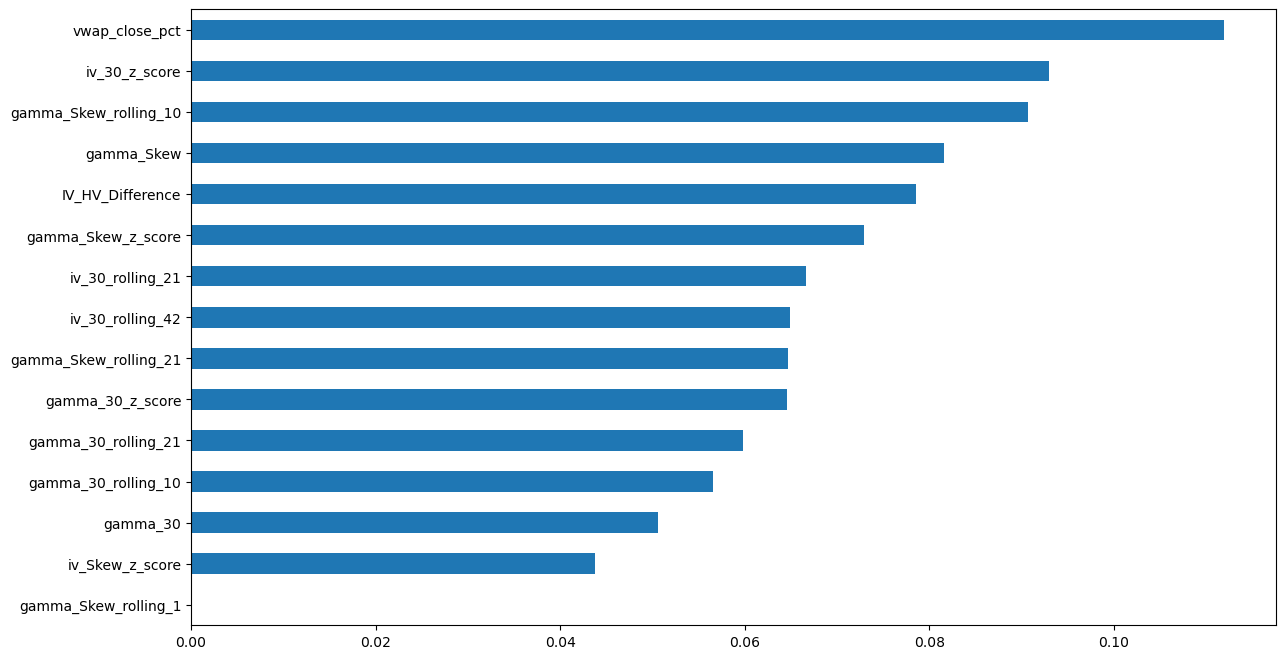

In [28]:
feat_importances.sort_values(ascending = True).plot(kind='barh', figsize = (14, 8))

In [30]:
# Generate predictions
y_pred = model.predict(X_test[columns_X_test])

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


In [32]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


R-squared: 0.5783477624320263


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 0.486647693444372
Mean Squared Error: 0.44504999923168076
Root Mean Squared Error: 0.6671206781622653


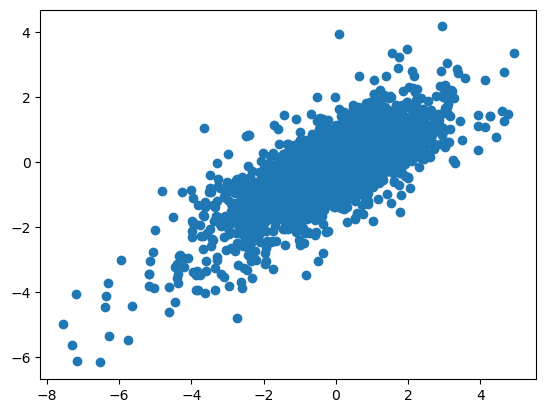

In [35]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)

In [36]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=2)
pca.fit(X[columns_X_test])
print(pca.explained_variance_ratio_)
pca_ = pca.transform(X[columns_X_test])
df_pca = pd.DataFrame(pca_, columns = ['pca1', 'pca2'])

[0.8822454  0.09869878]


In [50]:
df_pca['z_score_returns'] = y

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [67]:
# Create X, y variables
X = df_pca[['pca1', 'pca2']].astype(float)
y = df_pca['z_score_returns']

In [64]:
x1_min = X.pca1.mean() - X.pca1.std() * 1.5
x1_max = X.pca1.mean() + X.pca1.std() * 1.5
x1_diff = (x1_max - x1_min) / 50

x2_min = X.pca2.mean() - X.pca2.std() * 1.5
x2_max = X.pca2.mean() + X.pca2.std() * 1.5
x2_diff = (x2_max - x2_min) / 50

x1 = np.arange(x1_min, x1_max, x1_diff)
x2 = np.arange(x2_min, x2_max, x2_diff)

In [101]:
model_lr = LinearRegression().fit(X.values, y)

scale_data_ = True

# Optionally, scale data (*this should always be done)
if scale_data_:
    scale = StandardScaler()
    X_scaled = scale.fit_transform(X.values)
    model_lr = LinearRegression().fit(X_scaled, y)
    
results = []
for i in x1:
    for ii in x2:

        # Scale the values based on our X variable
        if scale_data_:
            scaled_values = scale.transform([[i, ii]])[0]
            i_ = scaled_values[0]
            ii_ = scaled_values[1]
        else:
            i_ = i
            ii_ = ii

        # Project hypothetical market performance (relative to average) and save
        yhat = model_lr.predict([[i_, ii_]])[0]
        # pct_diff = round((yhat - avg) / avg, 3)
        results.append([i, ii, yhat])




In [102]:
# Format results
df_exp = pd.DataFrame(results)
df_exp.columns = ['pca1', 'pca2', 'z_score_returns']

# Coerce down to 600 total rows for compatibility with amCharts
# df_exp = df_exp[::17].iloc[:600].reset_index(drop = True)
df_exp = df_exp.round(3)
print('Total length of heatmap dataframe: {}'.format(str(df_exp.shape[0])))




Total length of heatmap dataframe: 2500


Text(0, 0.5, 'pca2')

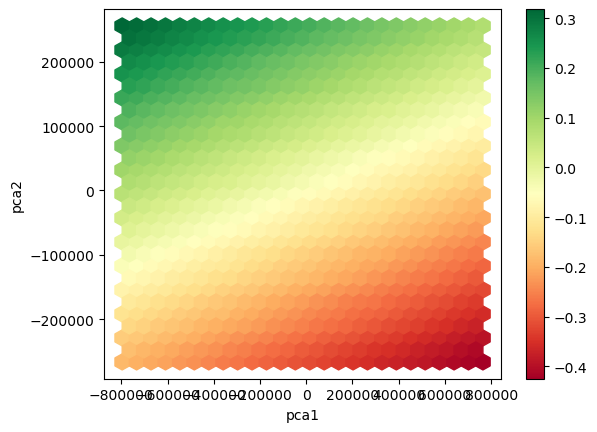

In [103]:
import matplotlib.pyplot as plt
plt.hexbin(df_exp['pca1'], df_exp['pca2'], C = df_exp['z_score_returns'], cmap="RdYlGn", gridsize=25)
#plt.clim(-2, 2)
plt.colorbar()
plt.xlabel('pca1')
plt.ylabel('pca2')

### What does a time series of the first principal component look like for individual stocks?

In [82]:
df_repo.keys()

dict_keys(['WAT', 'ATO', 'TYL', 'CHRW', 'AEP', 'CDAY', 'PRU', 'PODD', 'FE', 'OKE', 'REGN', 'LHX', 'LVS', 'V', 'CHTR', 'KLAC', 'WBA', 'AMGN', 'CTVA', 'EQT', 'ROL', 'BA', 'REG', 'RL', 'ROK', 'MPC', 'TSN', 'DPZ', 'GL', 'EXR', 'UNH', 'PEAK', 'MLM', 'PYPL', 'PWR', 'AMP', 'VRTX', 'FANG', 'JNPR', 'CTAS', 'FTNT', 'A', 'CCI', 'FOXA', 'ILMN', 'NUE', 'RMD', 'NSC', 'CBOE', 'HCA', 'CAT', 'CPRT', 'STT', 'HWM', 'WFC', 'EA', 'CMA', 'SYK', 'VTRS', 'FSLR', 'MAR', 'FTV', 'KO', 'TJX', 'PAYX', 'TT', 'EBAY', 'WBD', 'META', 'ACGL', 'MHK', 'DUK', 'ZBRA', 'LMT', 'WDC', 'CDNS', 'HON', 'DIS', 'MTB', 'CMS', 'ORCL', 'AIG', 'LH', 'WEC', 'AVB', 'LW', 'SPY', 'IQV', 'LKQ', 'EVRG', 'GME', 'DOW', 'MRNA', 'ELV', 'AAL', 'MSFT', 'MSCI', 'FOX', 'CAH', 'MAS', 'CSX', 'IRM'])

In [83]:
top_features = ['iv_30_rolling_21',
 'iv_30_rolling_42',
 'iv_30_z_score',
 'iv_Skew_z_score',
 'gamma_30',
 'gamma_Skew',
 'gamma_30_rolling_10',
 'gamma_30_rolling_21',
 'gamma_Skew_rolling_1',
 'gamma_Skew_rolling_10',
 'gamma_Skew_rolling_21',
 'gamma_30_z_score',
 'gamma_Skew_z_score',
 'IV_HV_Difference',
 'vwap_close_pct']

all_features = [x for x in top_features] + ['z_score_returns']

In [84]:
df_repo['AEP'][top_features].head()

,iv_30_rolling_21,iv_30_rolling_42,iv_30_z_score,iv_Skew_z_score,gamma_30,gamma_Skew,gamma_30_rolling_10,gamma_30_rolling_21,gamma_Skew_rolling_1,gamma_Skew_rolling_10,gamma_Skew_rolling_21,gamma_30_z_score,gamma_Skew_z_score,IV_HV_Difference,vwap_close_pct
2018-10-25,0.175419,0.163307,0.989125,-0.972624,40025.66,-3.195859,79177.431,63105.314762,-3.195859,-4.089820,-4.507520,-0.160138,0.179468,-0.003643,1.034653
2018-10-26,0.177452,0.164743,0.991209,-1.061850,38267.60,-2.656222,74855.168,64232.449524,-2.656222,-4.010336,-4.536467,-0.202914,0.345146,-0.004980,1.022106
2018-10-29,0.180529,0.166305,1.061941,-1.109195,35870.80,-2.796139,69865.175,64872.063810,-2.796139,-3.956077,-4.547938,-0.259321,0.300191,-0.008451,1.039173
2018-10-30,0.182976,0.167595,0.693900,-1.334367,37727.96,-3.012321,60004.316,64543.571429,-3.012321,-3.681149,-4.483746,-0.223177,0.232551,-0.018478,1.041383
2018-10-31,0.185367,0.168860,0.582691,-1.078509,63614.90,-3.805068,51450.329,65654.381429,-3.805068,-3.440302,-4.474980,0.337181,-0.011714,-0.016038,1.027348


In [85]:
from sklearn.decomposition import PCA

In [86]:
ticker = 'AEP'
df_pca_ = df_repo[ticker][all_features].copy()

# Perform PC
pca = PCA(n_components=1)
pca.fit(df_pca_[top_features])
print(pca.explained_variance_ratio_)
pca_ = pca.transform(df_pca_[top_features])
df_pca = pd.DataFrame(pca_, columns = ['pca1'],  index = df_pca_.index)

[0.84754751]


In [87]:
df_pca.join(df_pca_['z_score_returns']).corr().round(3)

,pca1,z_score_returns
pca1,1.000,0.053
z_score_returns,0.053,1.000


<AxesSubplot:>

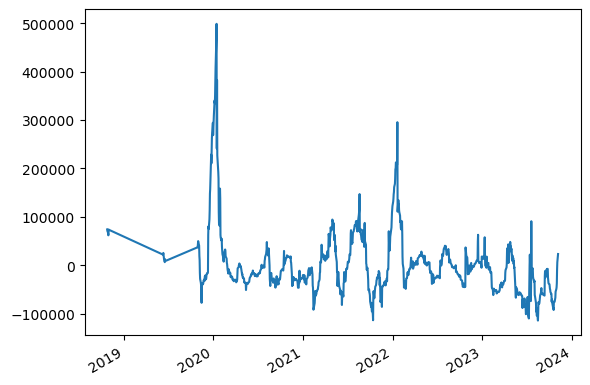

In [88]:
df_pca['pca1'].plot()

### Removing vwap close percent from features... does the first principal component still highly correlate to returns?

In [89]:
top_features_ = [x for x in top_features if not x == 'vwap_close_pct']

In [90]:
df_pca_ = df_repo[ticker][all_features].copy()

# Perform PC
pca = PCA(n_components=1)
pca.fit(df_pca_[top_features_])
print(pca.explained_variance_ratio_)
pca_ = pca.transform(df_pca_[top_features_])
df_pca = pd.DataFrame(pca_, columns = ['pca1'],  index = df_pca_.index)

[0.84754751]


### Look at S&P 500 (SPY) and create a principal component... does it also correlate (or predict) market returns?

In [131]:
ticker = 'SPY'
df_pca_ = df_repo[ticker][all_features].copy()

# Perform PC
pca = PCA(n_components=2)
pca.fit(df_pca_[top_features])
print(pca.explained_variance_ratio_)
pca_ = pca.transform(df_pca_[top_features])
df_pca = pd.DataFrame(pca_, columns = ['pca1', 'pca2'],  index = df_pca_.index)

[0.74156572 0.18816266]


In [132]:
df_pca.join(df_pca_['z_score_returns']).corr().round(3)

,pca1,pca2,z_score_returns
pca1,1.000,0.113,0.338
pca2,0.113,1.000,-0.336
z_score_returns,0.338,-0.336,1.000


<AxesSubplot:>

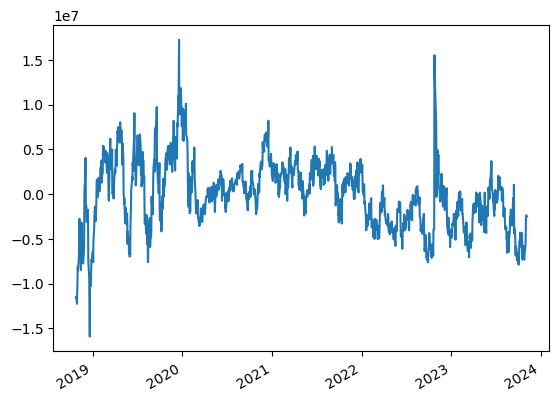

In [133]:
df_pca['pca1'].plot()

### Predicting SPY returns using only principal components 

In [136]:
# Preprocessing
X = df_pca
y = df_pca_['z_score_returns']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Assuming df is your DataFrame


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# Prediction and Evaluation
predictions = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

# Cross-Validation
scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
cv_rmse = np.sqrt(-scores)
print(f"CV RMSE: {cv_rmse.mean()}")


RMSE: 0.929913411273747
CV RMSE: 0.8613890702385391


In [138]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")


R-squared: 0.3323968170648236


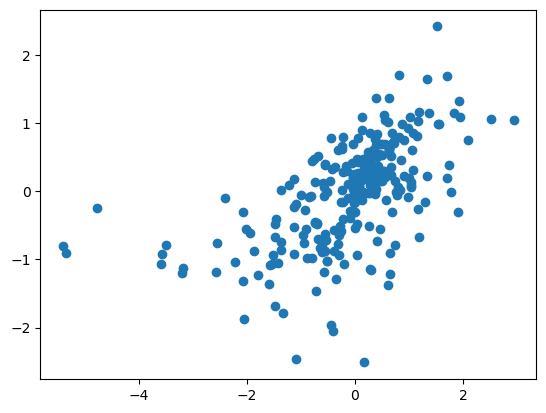

In [139]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions)

### Add in this principal component of top features back into our original feature pool (100+ features)... does it still come out the other side as a "top" feature (it should)

In [95]:
df_data = pd.concat(df_repo.values()).reset_index().drop('index', axis = 1).dropna()

In [109]:
valid_columns = [x for x in df_data.columns if not x == 'z_score_returns']

In [117]:
# df_pca_ = df_data[valid_columns].copy()

# Perform PC
pca = PCA(n_components=2)
pca.fit(df_data[top_features])
print(pca.explained_variance_ratio_)
pca_ = pca.transform(df_data[top_features])
df_pca = pd.DataFrame(pca_, columns = ['pca1', 'pca2'],  index = df_data.index)



[0.8005057 0.1504723]


In [119]:
df_pca.join(df_data['z_score_returns']).corr().round(3)

,pca1,pca2,z_score_returns
pca1,1.000,-0.000,0.084
pca2,-0.000,1.000,-0.126
z_score_returns,0.084,-0.126,1.000


<AxesSubplot:>

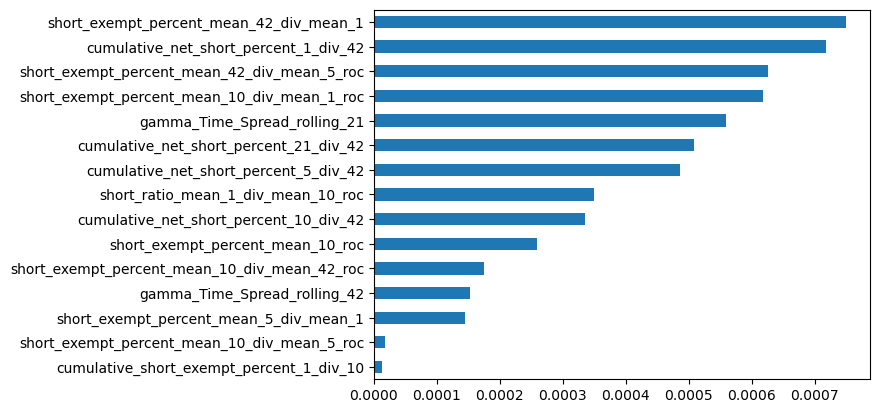

In [116]:
df_data.corr()['z_score_returns'].abs().sort_values(ascending = True).drop('z_score_returns').iloc[:15].plot.barh()

In [121]:
df_data = df_data.join(df_pca).copy()

In [122]:
from sklearn.model_selection import train_test_split

In [123]:
# Preprocessing
X = df_data.drop('z_score_returns', axis=1)
y = df_data['z_score_returns']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [126]:
# Instantiate class
model_obj = RegressorRFE()
model_obj.verbose = 3
model_obj.n_features_to_select = 17

# Fit data
model = model_obj.fit(X_train, y_train)




Final date in training:  15795
Fitting estimator with 172 features.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10836
[LightGBM] [Info] Number of data points in the train set: 79411, number of used features: 172
[LightGBM] [Info] Start training from score -0.022167


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:292: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Fitting estimator with 86 features.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5418
[LightGBM] [Info] Number of data points in the train set: 79411, number of used features: 86
[LightGBM] [Info] Start training from score -0.022167


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:292: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 79411, number of used features: 17
[LightGBM] [Info] Start training from score -0.022167


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:292: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 79411, number of used features: 17
[LightGBM] [Info] Start training from score -0.022167


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:292: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


In [130]:
columns_X_test = list(model_obj.valid_columns_)
# print(X_test[columns_X_test])

In [128]:
# Calc feature importances 

feat_importances = pd.Series(model.feature_importances_, index=columns_X_test)
feat_importances = feat_importances / feat_importances.sum()

<AxesSubplot:>

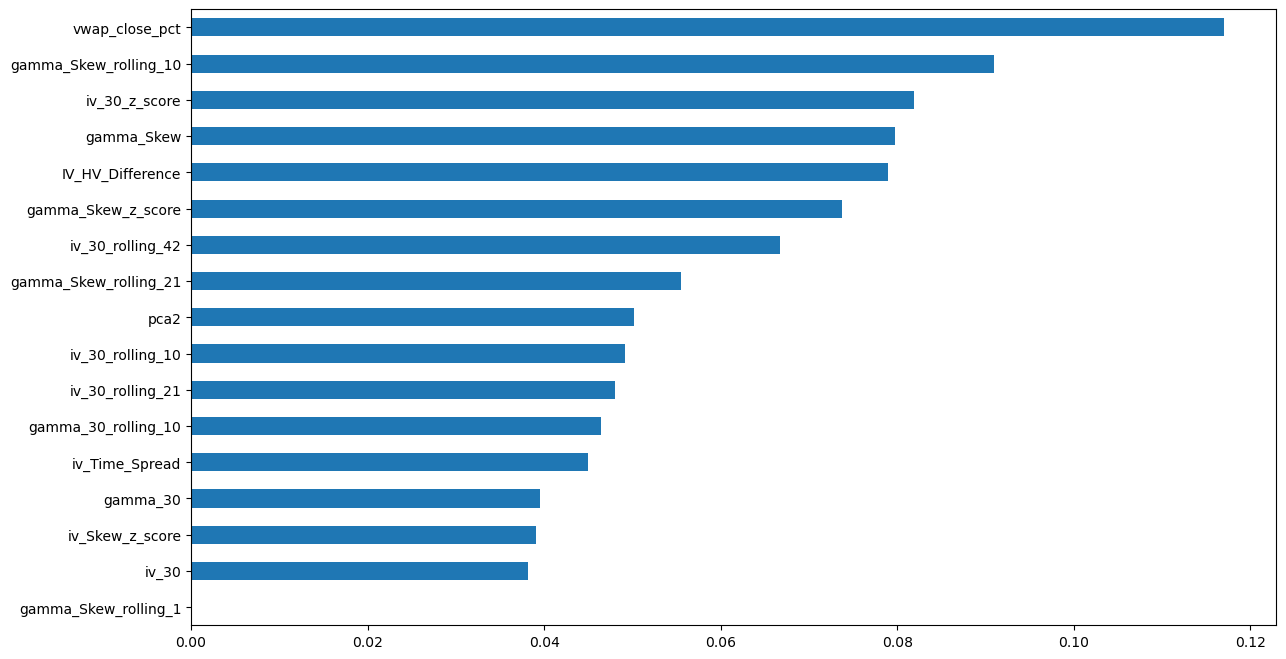

In [129]:
feat_importances.sort_values(ascending = True).plot(kind='barh', figsize = (14, 8))

### Predicting SPY Returns